# R vs Python Pipeline Output Comparison

Loads the CSV outputs written by `R/Preproc.R` and `Python/Preproc.ipynb` from
`data_out_temp/` and compares them at the protein matrix and alpha-peptide levels.

In [38]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr, spearmanr
%matplotlib inline

data_out = os.path.normpath(os.path.join(os.getcwd(), '../data_out_temp')) + '/'

---
## 1. Load outputs

In [39]:
r_prot  = pd.read_csv(os.path.join(data_out, 'R_pipeline_protein.csv'),  index_col=0)
py_prot = pd.read_csv(os.path.join(data_out, 'Python_pipeline_protein.csv'), index_col=0)

r_alpha  = pd.read_csv(os.path.join(data_out, 'R_pipeline_alpha_pep.csv'),  index_col=0)
py_alpha = pd.read_csv(os.path.join(data_out, 'Python_pipeline_alpha_pep.csv'), index_col=0)

print('=== Protein matrix ===')
print(f'R:      {r_prot.shape[0]} proteins x {r_prot.shape[1]} cells')
print(f'Python: {py_prot.shape[0]} proteins x {py_prot.shape[1]} cells')
print()
print('=== Alpha-peptide matrix ===')
print(f'R:      {r_alpha.shape[0]} peptides x {r_alpha.shape[1]} cells')
print(f'Python: {py_alpha.shape[0]} peptides x {py_alpha.shape[1]} cells')

=== Protein matrix ===
R:      2050 proteins x 250 cells
Python: 1954 proteins x 250 cells

=== Alpha-peptide matrix ===
R:      6208 peptides x 250 cells
Python: 6208 peptides x 250 cells


---
## 2. Overlap — proteins and cells

In [40]:
shared_prots = r_prot.index.intersection(py_prot.index)
shared_cells = r_prot.columns.intersection(py_prot.columns)

print(f'Shared proteins: {len(shared_prots)} / R={len(r_prot)} / Python={len(py_prot)}')
print(f'Shared cells:    {len(shared_cells)} / R={len(r_prot.columns)} / Python={len(py_prot.columns)}')

only_r   = set(r_prot.index)  - set(py_prot.index)
only_py  = set(py_prot.index) - set(r_prot.index)
print(f'Only in R:      {len(only_r)} proteins')
print(f'Only in Python: {len(only_py)} proteins')

Shared proteins: 1954 / R=2050 / Python=1954
Shared cells:    250 / R=250 / Python=250
Only in R:      96 proteins
Only in Python: 0 proteins


---
## 3. Cell-level correlation (per-cell mean protein level)

For each shared cell, correlate its protein vector between R and Python.

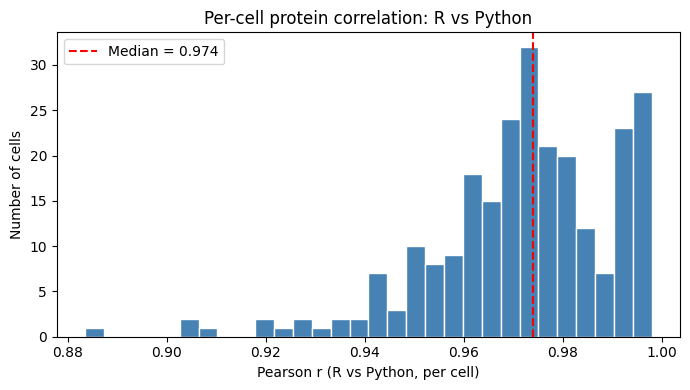

Median per-cell correlation: 0.9739
Cells with r > 0.9:          249/250


In [41]:
r_sub  = r_prot.loc[shared_prots, shared_cells]
py_sub = py_prot.loc[shared_prots, shared_cells]

cell_cors = []
for cell in shared_cells:
    rv = r_sub[cell].values.astype(float)
    pv = py_sub[cell].values.astype(float)
    ok = np.isfinite(rv) & np.isfinite(pv)
    if ok.sum() >= 5:
        cell_cors.append(pearsonr(rv[ok], pv[ok])[0])
    else:
        cell_cors.append(np.nan)

cell_cors = np.array(cell_cors)

fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(cell_cors[np.isfinite(cell_cors)], bins=30, color='steelblue', edgecolor='white')
ax.axvline(np.nanmedian(cell_cors), color='red', linestyle='--',
           label=f'Median = {np.nanmedian(cell_cors):.3f}')
ax.set_xlabel('Pearson r (R vs Python, per cell)')
ax.set_ylabel('Number of cells')
ax.set_title('Per-cell protein correlation: R vs Python')
ax.legend()
plt.tight_layout()
plt.show()

print(f'Median per-cell correlation: {np.nanmedian(cell_cors):.4f}')
print(f'Cells with r > 0.9:          {np.sum(cell_cors > 0.9)}/{len(cell_cors)}')

---
## 4. Protein-level correlation (per-protein mean across cells)

For each shared protein, correlate its cell vector between R and Python.

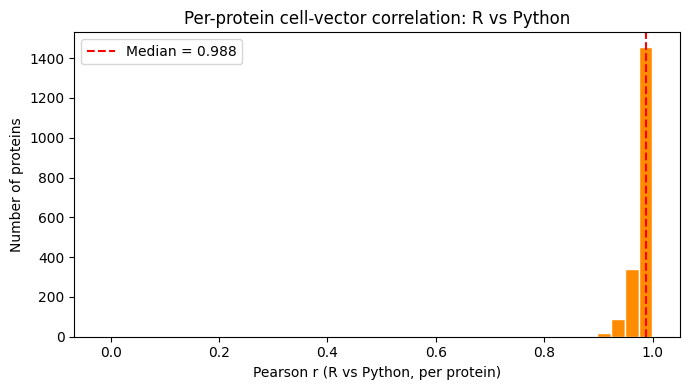

Median per-protein correlation: 0.9881
Proteins with r > 0.9:          1905/1922


In [42]:
prot_cors = []
prot_ids  = []
for prot in shared_prots:
    rv = r_sub.loc[prot].values.astype(float)
    pv = py_sub.loc[prot].values.astype(float)
    ok = np.isfinite(rv) & np.isfinite(pv)
    if ok.sum() >= 5:
        prot_cors.append(pearsonr(rv[ok], pv[ok])[0])
        prot_ids.append(prot)
    else:
        prot_cors.append(np.nan)
        prot_ids.append(prot)

prot_cors = np.array(prot_cors)

fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(prot_cors[np.isfinite(prot_cors)], bins=40, color='darkorange', edgecolor='white')
ax.axvline(np.nanmedian(prot_cors), color='red', linestyle='--',
           label=f'Median = {np.nanmedian(prot_cors):.3f}')
ax.set_xlabel('Pearson r (R vs Python, per protein)')
ax.set_ylabel('Number of proteins')
ax.set_title('Per-protein cell-vector correlation: R vs Python')
ax.legend()
plt.tight_layout()
plt.show()

print(f'Median per-protein correlation: {np.nanmedian(prot_cors):.4f}')
print(f'Proteins with r > 0.9:          {np.sum(prot_cors > 0.9)}/{np.sum(np.isfinite(prot_cors))}')

---
## 5. Scatter: all individual values (R vs Python)

Every (protein × cell) value plotted against each other — more meaningful since data is row-normalized to the mean.

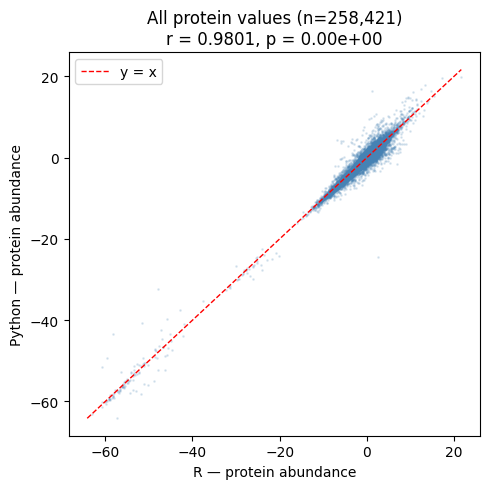

In [43]:
r_vals  = r_sub.values.flatten().astype(float)
py_vals = py_sub.values.flatten().astype(float)

ok = np.isfinite(r_vals) & np.isfinite(py_vals)
r_val, pval = pearsonr(r_vals[ok], py_vals[ok])

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(r_vals[ok], py_vals[ok], s=1, alpha=0.15, color='steelblue', rasterized=True)
lims = [min(r_vals[ok].min(), py_vals[ok].min()),
        max(r_vals[ok].max(), py_vals[ok].max())]
ax.plot(lims, lims, 'r--', linewidth=1, label='y = x')
ax.set_xlabel('R — protein abundance')
ax.set_ylabel('Python — protein abundance')
ax.set_title(f'All protein values (n={ok.sum():,})\nr = {r_val:.4f}, p = {pval:.2e}')
ax.legend()
plt.tight_layout()
plt.show()

---
## 6. Alpha-peptide matrix comparison

Same overlap + correlation analysis on the miceotope alpha (fractional synthesis) values.

Shared alpha peptides: 6208 / R=6208 / Python=6208
Shared cells:          250


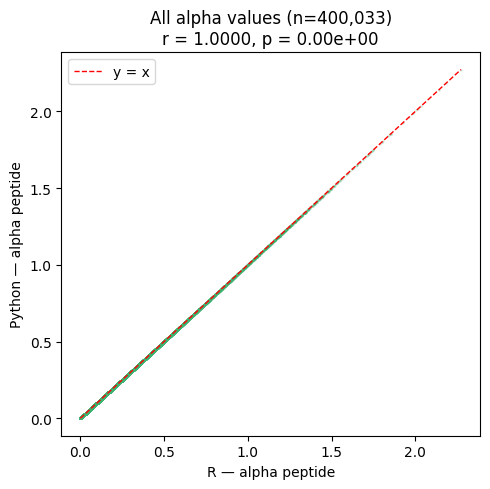

In [44]:
shared_peps    = r_alpha.index.intersection(py_alpha.index)
shared_cells_a = r_alpha.columns.intersection(py_alpha.columns)

print(f'Shared alpha peptides: {len(shared_peps)} / R={len(r_alpha)} / Python={len(py_alpha)}')
print(f'Shared cells:          {len(shared_cells_a)}')

r_a_sub  = r_alpha.loc[shared_peps, shared_cells_a]
py_a_sub = py_alpha.loc[shared_peps, shared_cells_a]

r_a_vals  = r_a_sub.values.flatten().astype(float)
py_a_vals = py_a_sub.values.flatten().astype(float)
ok = np.isfinite(r_a_vals) & np.isfinite(py_a_vals)
r_a_r, r_a_p = pearsonr(r_a_vals[ok], py_a_vals[ok])

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(r_a_vals[ok], py_a_vals[ok], s=1, alpha=0.15, color='mediumseagreen', rasterized=True)
lims = [min(r_a_vals[ok].min(), py_a_vals[ok].min()),
        max(r_a_vals[ok].max(), py_a_vals[ok].max())]
ax.plot(lims, lims, 'r--', linewidth=1, label='y = x')
ax.set_xlabel('R — alpha peptide')
ax.set_ylabel('Python — alpha peptide')
ax.set_title(f'All alpha values (n={ok.sum():,})\nr = {r_a_r:.4f}, p = {r_a_p:.2e}')
ax.legend()
plt.tight_layout()
plt.show()

In [29]:
py_alpha.index

Index(['GAAQNIIPASTGAAK3.0', 'GAAQNIIPASTGAAK4.0', 'QASEGPLK2.0',
       'TVDGPSGK2.0', 'VIISAPSADAPMFVMGVNHEK4.0', 'VIPELNGK2.0',
       'VVDLMAYMASK3.0', 'WGEAGAEYVVESTGVFTTMEK4.0', 'VILNPVNTNLSK3.0',
       'DVSEGLSDLK3.0',
       ...
       'ITGEAFVQFASQELAEK4.0', 'QSGEAFVELESEDDVK3.0', 'SYSDPPLK3.0',
       'VTGEADVEFATHEEAVAAMSK4.0', 'TFGENYVQELLEK3.0', 'DVPASGMYFMTYEWLK3.0',
       'EEGVTSLYK3.0', 'FQTAPPGK2.0', 'NLFTPEGK2.0', 'NLFTPEGK3.0'],
      dtype='str', length=6208)

---
## 7. Comparison of protein intensitites before batch correction

Shared proteins: 1954 / R=2050 / Python=1954
Shared cells:    250
Only in R:      96 proteins
Only in Python: 0 proteins


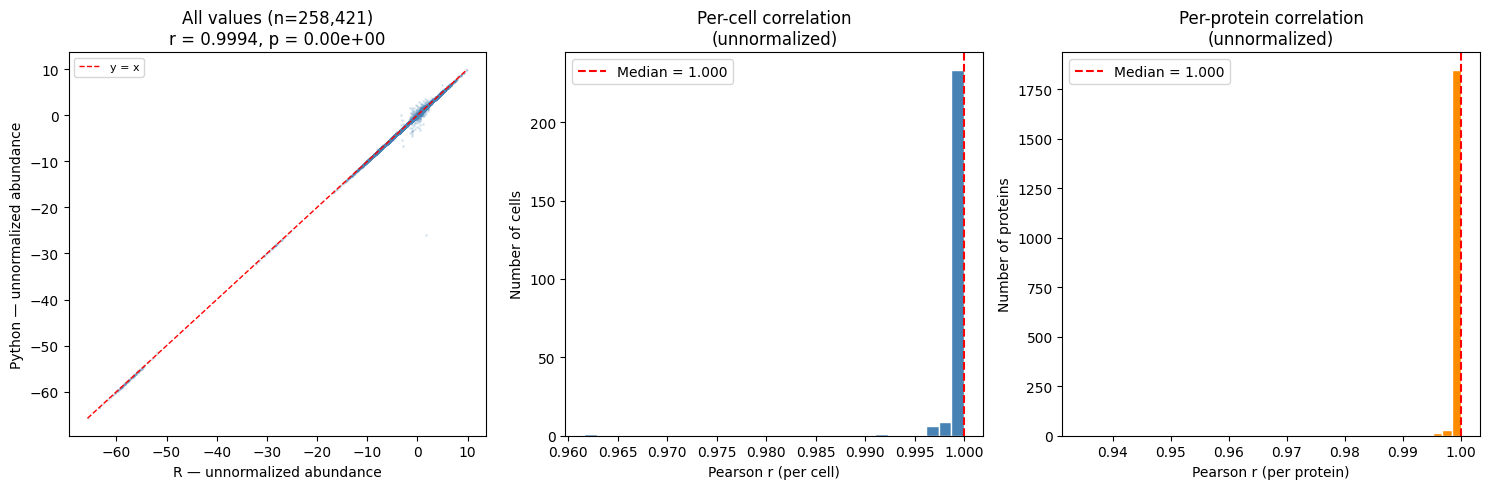

Global r (all values):          0.9994
Median per-cell correlation:    1.0000
Median per-protein correlation: 1.0000


In [45]:
r_unprot  = pd.read_csv(os.path.join(data_out, 'R_pipeline_nonorm_protein.csv'),  index_col=0)
py_unprot = pd.read_csv(os.path.join(data_out, 'Python_unnormalized_pipeline_protein.csv'), index_col=0)

shared_prots_un = r_unprot.index.intersection(py_unprot.index)
shared_cells_un = r_unprot.columns.intersection(py_unprot.columns)

print(f'Shared proteins: {len(shared_prots_un)} / R={len(r_unprot)} / Python={len(py_unprot)}')
print(f'Shared cells:    {len(shared_cells_un)}')
only_r_un  = set(r_unprot.index)  - set(py_unprot.index)
only_py_un = set(py_unprot.index) - set(r_unprot.index)
print(f'Only in R:      {len(only_r_un)} proteins')
print(f'Only in Python: {len(only_py_un)} proteins')

r_un_sub  = r_unprot.loc[shared_prots_un, shared_cells_un]
py_un_sub = py_unprot.loc[shared_prots_un, shared_cells_un]

# Per-cell correlation
cell_cors_un = []
for cell in shared_cells_un:
    rv = r_un_sub[cell].values.astype(float)
    pv = py_un_sub[cell].values.astype(float)
    ok = np.isfinite(rv) & np.isfinite(pv)
    cell_cors_un.append(pearsonr(rv[ok], pv[ok])[0] if ok.sum() >= 5 else np.nan)
cell_cors_un = np.array(cell_cors_un)

# Per-protein correlation
prot_cors_un = []
for prot in shared_prots_un:
    rv = r_un_sub.loc[prot].values.astype(float)
    pv = py_un_sub.loc[prot].values.astype(float)
    ok = np.isfinite(rv) & np.isfinite(pv)
    prot_cors_un.append(pearsonr(rv[ok], pv[ok])[0] if ok.sum() >= 5 else np.nan)
prot_cors_un = np.array(prot_cors_un)

# ── Main figure: scatter of ALL individual values ──────────────────────────
r_un_vals  = r_un_sub.values.flatten().astype(float)
py_un_vals = py_un_sub.values.flatten().astype(float)
ok_un = np.isfinite(r_un_vals) & np.isfinite(py_un_vals)
r_un_r, r_un_p = pearsonr(r_un_vals[ok_un], py_un_vals[ok_un])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Scatter — all values (primary)
axes[0].scatter(r_un_vals[ok_un], py_un_vals[ok_un],
                s=1, alpha=0.15, color='steelblue', rasterized=True)
lims_un = [min(r_un_vals[ok_un].min(), py_un_vals[ok_un].min()),
           max(r_un_vals[ok_un].max(), py_un_vals[ok_un].max())]
axes[0].plot(lims_un, lims_un, 'r--', linewidth=1, label='y = x')
axes[0].set_xlabel('R — unnormalized abundance')
axes[0].set_ylabel('Python — unnormalized abundance')
axes[0].set_title(f'All values (n={ok_un.sum():,})\nr = {r_un_r:.4f}, p = {r_un_p:.2e}')
axes[0].legend(fontsize=8)

# 2. Per-cell correlation histogram
axes[1].hist(cell_cors_un[np.isfinite(cell_cors_un)], bins=30, color='steelblue', edgecolor='white')
axes[1].axvline(np.nanmedian(cell_cors_un), color='red', linestyle='--',
                label=f'Median = {np.nanmedian(cell_cors_un):.3f}')
axes[1].set_xlabel('Pearson r (per cell)')
axes[1].set_ylabel('Number of cells')
axes[1].set_title('Per-cell correlation\n(unnormalized)')
axes[1].legend()

# 3. Per-protein correlation histogram
axes[2].hist(prot_cors_un[np.isfinite(prot_cors_un)], bins=40, color='darkorange', edgecolor='white')
axes[2].axvline(np.nanmedian(prot_cors_un), color='red', linestyle='--',
                label=f'Median = {np.nanmedian(prot_cors_un):.3f}')
axes[2].set_xlabel('Pearson r (per protein)')
axes[2].set_ylabel('Number of proteins')
axes[2].set_title('Per-protein correlation\n(unnormalized)')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f'Global r (all values):          {r_un_r:.4f}')
print(f'Median per-cell correlation:    {np.nanmedian(cell_cors_un):.4f}')
print(f'Median per-protein correlation: {np.nanmedian(prot_cors_un):.4f}')